Install and Import Libraries

In [1]:
# Install
!pip install geopandas mapclassify pandas

# Import required libraries
import geopandas as gpd
import mapclassify
import numpy as np
import pandas as pd


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


Provided Data

In [2]:
# Link to the GeoPackage file
link = "https://github.com/DACSS-CSSmeths/Spatial-Exploring/raw/refs/heads/main/maps/countriesCIA.gpkg"

# List of maps
gpd.list_layers(link)


,name,geometry_type
0,cia,MultiPolygon
1,border,MultiPolygon


In [3]:
# Open and read map files
countriesCIA = gpd.read_file(link, layer='cia')  # Load country data
worldBorders = gpd.read_file(link, layer='border')  # Load world borders for R


In [4]:
# See some rows
countriesCIA.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   COUNTRY               147 non-null    object  
 1   name                  147 non-null    object  
 2   region                147 non-null    object  
 3   obesityAdults_rate    147 non-null    float64 
 4   TobaccoUse_perc       147 non-null    float64 
 5   Alcohol_LitersPerCap  147 non-null    float64 
 6   tobacco_code          147 non-null    int64   
 7   tobacco_levels        147 non-null    object  
 8   tobacco_custom        147 non-null    object  
 9   alcohol_code          147 non-null    int64   
 10  alcohol_levels        147 non-null    object  
 11  geometry              147 non-null    geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 13.9+ KB


Categorize Obesity/Adults into 5 Groups

<Axes: title={'center': 'Classification ADCM Scores'}, ylabel='Classifier'>

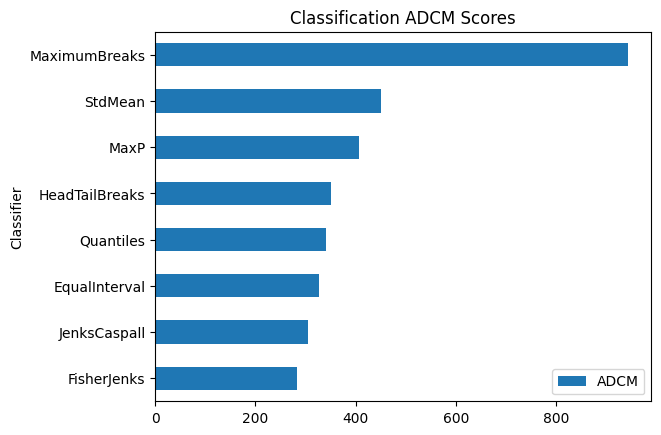

In [5]:
# !pip install pysal
# Set a fixed seed
np.random.seed(12345)

# 5 Bins
K = 5

# Obesity
theVar = countriesCIA['obesityAdults_rate']

# Apply different classification schemes
ei5 = mapclassify.EqualInterval(theVar, k=K)   # Equal intervals
msd = mapclassify.StdMean(theVar)             # Standard deviation-based, same interval width
q5 = mapclassify.Quantiles(theVar, k=K)       # Quantiles-based, interval width varies
mb5 = mapclassify.MaximumBreaks(theVar, k=K)  # Maximum Breaks, multimodal data
fj5 = mapclassify.FisherJenks(theVar, k=K)    # Fisher-Jenks, optimizer (Optimal)
jc5 = mapclassify.JenksCaspall(theVar, k=K)   # Jenks-Caspall, optimizer
mp5 = mapclassify.MaxP(theVar, k=K)           # Max-P method, optimizer
ht = mapclassify.HeadTailBreaks(theVar)       # Head/Tail Breaks, skewed data, no k needed

# Create list of classifiers
class5 = [ei5, msd, q5, mb5, ht, fj5, jc5, mp5]

# Compute Absolute Deviation from Class Mean (ADCM) scores
fits = np.array([c.adcm for c in class5])

# DataFrame for ADCM scores and add classifers
adcms = pd.DataFrame(fits, columns=['ADCM'])
adcms['Classifier'] = [c.name for c in class5]

# See classifiers by ADCM and create chart
adcms.sort_values('ADCM').plot.barh(x='Classifier', title="Classification ADCM Scores")


Create New Columns for Obesity Categories

In [6]:
# Map of labels
newLevels = {0: '1.very low', 1: '2.low', 2: '3.average', 3: '4.high', 4: '5.very high'}

# Get values and assign Fisher-Jenks, yb contains bin classifications
countriesCIA['obesity_code'] = fj5.yb

# Copy values in new column
countriesCIA = countriesCIA.assign(obesity_levels=countriesCIA['obesity_code'])

# Recoding numeric categories
countriesCIA.replace({'obesity_levels': newLevels}, inplace=True)


Last Step, Update and Save Geopackage

In [7]:
# Save updated dataset with obesity classifications
countriesCIA.to_file('countriesCIA.gpkg', driver='GPKG', layer='cia')

# Save world borders
worldBorders.to_file('countriesCIA.gpkg', driver='GPKG', layer='border', mode='a')


Verify Layers

In [8]:
!pip install fiona


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 76.5 MB/s eta 0:00:00


In [9]:
import fiona

# List layers in saved GeoPackage
print("Layers in GeoPackage:", fiona.listlayers("countriesCIA.gpkg"))


Layers in GeoPackage: ['cia', 'border']


In [10]:
countriesCIA.loc[:, ['obesity_code', 'obesity_levels']]


,obesity_code,obesity_levels
0,0,1.very low
1,2,3.average
2,1,2.low
3,1,2.low
4,1,2.low
...,...,...
142,1,2.low
143,1,2.low
144,0,1.very low
145,1,2.low
